## Initilaization

In [ ]:
import numpy as np
import glob2
import datetime
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from notebooks.demo.Open_ISAS_Grid import travel_time
#
# from notebooks.demo.dev_asso_manual import model
from utils.detection.association import load_detections
from utils.detection.association import compute_grids
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model.spherical_sound_model import HomogeneousSphericalSoundModel as HomogeneousSoundModel
from utils.detection.association import compute_candidates, association_is_new, update_valid_grid, update_results

In [ ]:
# paths
CATALOG_PATH = "/media/rsafran/CORSAIR/OHASISBIO/recensement_stations_OHASISBIO_RS.csv"
# DETECTIONS_DIR = "/media/rsafran/CORSAIR/temp/2018"
DETECTIONS_DIR = "/home/rsafran/Bureau/tissnet/2018"
ASSOCIATION_OUTPUT_DIR = "../../../data/detection/association"

# Detections loading parameters
RELOAD_DETECTIONS = False # if False, load files called "detections.npy" and "detections_merged.npy" containing everything instead of the raw detection output. Leave at True by default
MIN_P_TISSNET_PRIMARY = 0.8  # min probability of browsed detections
MIN_P_TISSNET_SECONDARY = 0.6  # min probability of detections that can be associated with the browsed one
MERGE_DELTA_S = 10 # threshold below which we consider two events should be merged
MERGE_DELTA = datetime.timedelta(seconds=MERGE_DELTA_S)

REQ_CLOSEST_STATIONS = 0  # The REQ_CLOSEST_STATIONS th closest stations will be required for an association to be valid

# sound model definition
SOUND_MODEL = HomogeneousSoundModel(sound_speed=1485.5)

# association running parameters
RUN_ASSOCIATION = True # set to False to load previous associations without processing it again
SAVE_PATH_ROOT = None  # change this to save the grids as figures, leave at None by default
NCPUS = 20  # nb of CPUs used

In [ ]:
STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
DETECTIONS_DIR_NAME = DETECTIONS_DIR.split("/")[-1]

if RELOAD_DETECTIONS:
    det_files = [f for f in glob2.glob(DETECTIONS_DIR + "/*") if Path(f).is_file()]
    DETECTIONS, DETECTIONS_MERGED = load_detections(det_files, STATIONS, DETECTIONS_DIR, MIN_P_TISSNET_PRIMARY, MIN_P_TISSNET_SECONDARY, MERGE_DELTA)
else:
    DETECTIONS = np.load(f"{DETECTIONS_DIR}/cache/detections.npy", allow_pickle=True).item()
    DETECTIONS_MERGED = np.load(f"{DETECTIONS_DIR}/cache/detections_merged.npy", allow_pickle=True)

STATIONS = [s for s in DETECTIONS.keys()]
FIRSTS_DETECTIONS = {s : DETECTIONS[s][0,0] for s in STATIONS}
LASTS_DETECTIONS = {s : DETECTIONS[s][-1,0] for s in STATIONS}

In [ ]:
print(vars(STATIONS[0]))
print(STATIONS[0].depth)
print(STATIONS[0].name)
print(STATIONS[0].get_pos(include_depth=True))


In [ ]:
LAT_BOUNDS = [-60, 5]
LON_BOUNDS = [35, 120]
GRID_SIZE = 350  # number of points along each axis

(PTS_LAT, PTS_LON, STATION_MAX_TRAVEL_TIME, GRID_STATION_TRAVEL_TIME,
 GRID_STATION_COUPLE_TRAVEL_TIME, GRID_TOLERANCE) = compute_grids(LAT_BOUNDS, LON_BOUNDS, GRID_SIZE, SOUND_MODEL, STATIONS, pick_uncertainty=2, sound_speed_uncertainty=1)

## Association

In [19]:
print("starting association")

OUT_DIR = f"{ASSOCIATION_OUTPUT_DIR}/grids/{DETECTIONS_DIR_NAME}"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
OUT_FILE = f"{OUT_DIR}/s_{LAT_BOUNDS[0]}-{LAT_BOUNDS[1]},{LON_BOUNDS[0]}-{LON_BOUNDS[1]},{GRID_SIZE},{MIN_P_TISSNET_PRIMARY},{MIN_P_TISSNET_SECONDARY}.npy".replace(" ","")

association_hashlist = set()
associations = {}

def process_detection(arg):
    detection, local_association_hashlist = arg
    local_association = {}
    date1, p1, s1 = detection
    save_path = SAVE_PATH_ROOT
    if save_path is not None:
        save_path = f'{save_path}/{s1.name}-{date1.strftime("%Y%m%d_%H%M%S")}'
        Path(save_path).mkdir(parents=True, exist_ok=True)

    # list all other stations and sort them by distance from s1
    other_stations = np.array([s2 for s2 in STATIONS if s2 != s1
                               and date1 + datetime.timedelta(seconds=4*GRID_TOLERANCE) > FIRSTS_DETECTIONS[s2]
                               and date1 - datetime.timedelta(seconds=4*GRID_TOLERANCE) < LASTS_DETECTIONS[s2]])
    other_stations = other_stations[np.argsort([STATION_MAX_TRAVEL_TIME[s1][s2] for s2 in other_stations])]

    # given the detection date1 occurred on station s1, list all the detections of other stations that may be generated by the same source event
    current_association = {s1:date1}
    candidates =  compute_candidates(other_stations, current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, MERGE_DELTA_S)

    # update the list of other stations to only include the ones having at least a candidate detection
    other_stations = [s for s in other_stations if len(candidates[s]) > 0]

    if len(other_stations) < 2:
        return local_association, local_association_hashlist

    # define the recursive browsing function (that is responsible for browsing the search space of associations for s1-date1)
    def backtrack(station_index, current_association, valid_grid, associations, save_path):
        if station_index == len(other_stations):
            return
        station = other_stations[station_index]

        candidates = compute_candidates([station], current_association, DETECTIONS, STATION_MAX_TRAVEL_TIME, MERGE_DELTA_S)
        for idx in candidates[station]:
            date, p = DETECTIONS[station][idx]
            if not association_is_new(current_association, date, local_association_hashlist):
                continue

            valid_grid_new, dg_new = update_valid_grid(current_association, valid_grid, station, date, GRID_STATION_COUPLE_TRAVEL_TIME, GRID_TOLERANCE, save_path, LON_BOUNDS, LAT_BOUNDS)

            valid_points_new = np.argwhere(valid_grid_new)

            if len(valid_points_new) > 0:
                current_association[station] = (date)

                if len(current_association) > 2:
                    update_results(date1, current_association, valid_points_new, local_association, GRID_STATION_COUPLE_TRAVEL_TIME)

                backtrack(station_index + 1, current_association, valid_grid_new, associations, save_path)
                del current_association[station]
        # also try without self
        if station_index >= REQ_CLOSEST_STATIONS:
            backtrack(station_index + 1, current_association, valid_grid, associations, save_path)
        return
    backtrack(0, current_association, None, associations, save_path=save_path)
    return local_association, local_association_hashlist

# main part
if RUN_ASSOCIATION:
    try:
        with ProcessPoolExecutor(NCPUS) as executor:
            futures = {executor.submit(process_detection, (det, association_hashlist)): det for det in DETECTIONS_MERGED}
            for future in tqdm(as_completed(futures), total=len(futures)):
                local_association, local_association_hashlist = future.result()
                association_hashlist = association_hashlist.union(local_association_hashlist)
                associations = associations | local_association
    finally:
        # save the associations no matter if the execution stopped properly
        np.save(OUT_FILE, associations)

starting association


NameError: name 'ASSOCIATION_OUTPUT_DIR' is not defined

## plotting density map

In [ ]:
OUT_DIR = f"{ASSOCIATION_OUTPUT_DIR}/grids/{DETECTIONS_DIR_NAME}"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
OUT_FILE = f"{OUT_DIR}/s_{LAT_BOUNDS[0]}-{LAT_BOUNDS[1]},{LON_BOUNDS[0]}-{LON_BOUNDS[1]},{GRID_SIZE},{MIN_P_TISSNET_PRIMARY},{MIN_P_TISSNET_SECONDARY}.npy".replace(" ","")
valid = np.zeros((GRID_SIZE,GRID_SIZE))

MIN_SIZE = 7

# load every npy file in the output directory and create a grid containing associations with cardinal >= 4
for f in tqdm(glob2.glob(f"{OUT_FILE[:-4]}*.npy")):
    associations = np.load(f, allow_pickle=True).item()
    for date, associations_ in associations.items():
        for (detections, valid_points) in associations_:
            if len(detections) > MIN_SIZE:
                continue
            for i, j in valid_points:
                valid[i,j] += 1

plt.figure(figsize=(15,10))
extent = (LON_BOUNDS[0], LON_BOUNDS[-1], LAT_BOUNDS[0], LAT_BOUNDS[-1])
im = plt.imshow(valid[::-1], aspect=1, cmap="inferno", extent=extent, interpolation=None, vmax=250)
cbar = plt.colorbar(im)
cbar.set_label('Nb of associations')

for s in STATIONS:
    p = s.get_pos()

    if p[0] > LAT_BOUNDS[1] or p[0] < LAT_BOUNDS[0] or p[1] > LON_BOUNDS[1] or p[1] < LON_BOUNDS[0]:
        print(f"Station {s.name} out of bounds")
        continue
    plt.plot(p[1], p[0], 'wx', alpha=0.75)
    plt.annotate(s.name, xy=(p[1], p[0]), xytext=(p[1]-(LON_BOUNDS[1]-LON_BOUNDS[0])/15, p[0]+(LAT_BOUNDS[1]-LAT_BOUNDS[0])/100), textcoords="data", color='w', alpha=0.9)

In [ ]:
plt.figure(figsize=(15,10))
extent = (LON_BOUNDS[0], LON_BOUNDS[-1], LAT_BOUNDS[0], LAT_BOUNDS[-1])
im = plt.imshow(valid[::-1], aspect=1, cmap="inferno", extent=extent, interpolation=None, vmax=800)
cbar = plt.colorbar(im)
cbar.set_label('Nb of associations')
cbar = plt.colorbar(im)
cbar.set_label('Nb of associations')

for s in STATIONS:
    p = s.get_pos()

    if p[0] > LAT_BOUNDS[1] or p[0] < LAT_BOUNDS[0] or p[1] > LON_BOUNDS[1] or p[1] < LON_BOUNDS[0]:
        print(f"Station {s.name} out of bounds")
        continue
    plt.plot(p[1], p[0], 'wx', alpha=0.75)
    plt.annotate(s.name, xy=(p[1], p[0]), xytext=(p[1]-(LON_BOUNDS[1]-LON_BOUNDS[0])/15, p[0]+(LAT_BOUNDS[1]-LAT_BOUNDS[0])/100), textcoords="data", color='w', alpha=0.9)

In [ ]:
valid = np.zeros((GRID_SIZE,GRID_SIZE))

MIN_SIZE =6

# load every npy file in the output directory and create a grid containing associations with cardinal >= 4
for f in tqdm(glob2.glob(f"{OUT_FILE[:-4]}*.npy")):
    associations = np.load(f, allow_pickle=True).item()
    for date, associations_ in associations.items():
        for (detections, valid_points) in associations_:
            if len(detections) < MIN_SIZE:
                continue
            for i, j in valid_points:
                valid[i,j] += 1

# Create a figure with cartopy's PlateCarree projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

# Set the extent of the map (min_lon, max_lon, min_lat, max_lat)
ax.set_extent([LON_BOUNDS[0], LON_BOUNDS[1], LAT_BOUNDS[0], LAT_BOUNDS[1]], crs=projection)

# Add natural features: land, ocean, and coastlines.
# These features will be drawn on top if the image is behind.
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', zorder=3)

# Plot the georeferenced image.
# Set a lower zorder (e.g., 1) so that the map features drawn with higher zorders remain visible.
# Adjust alpha to add a bit of transparency if desired.
extent = (LON_BOUNDS[0], LON_BOUNDS[1], LAT_BOUNDS[0], LAT_BOUNDS[1])
im = ax.imshow(valid[::-1],
               cmap="winter",
               extent=extent,
               interpolation="nearest",
               origin='upper',
               transform=projection,
               zorder=1,
               alpha=1, vmax=10)

# Add a colorbar for the image.
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Nb of associations')

# Plot station markers and add annotations using the axes methods.
for s in STATIONS:
    lat, lon = s.get_pos()
    if lat > LAT_BOUNDS[1] or lat < LAT_BOUNDS[0] or lon > LON_BOUNDS[1] or lon < LON_BOUNDS[0]:
        print(f"Station {s.name} out of bounds")
        continue
    # Plot a marker with a higher zorder so it's on top of the image
    ax.plot(lon, lat, 'wx', alpha=0.75, markersize=8, transform=projection, zorder=4)
    ax.text(lon - (LON_BOUNDS[1] - LON_BOUNDS[0]) / 15,
            lat + (LAT_BOUNDS[1] - LAT_BOUNDS[0]) / 100,
            s.name,
            color='white',
            alpha=0.9,
            transform=projection,
            zorder=4)

plt.title("Association Data with Land and Sea")
plt.show()


In [ ]:
path_asso = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"
associations = np.load(path_asso, allow_pickle=True).item()

In [ ]:
for date, associations_ in associations.items():
    print(date)
    for (detections, valid_points) in associations_:
        detection = detections
        valid_point = valid_points
        print(detections)
        break
    break
detections[0,0] #station object
detection[0,0].name #station name
detection[0,0].get_pos() #station position (lat, lon)
detections[0,1] #datetime object of detection at corresponding station
valid_points #points on the grid that are candidates for the group of detections

## To Dataframe

In [ ]:
import numpy as np
import pandas as pd

# Path to your saved associations file.
path_asso = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"

# Load associations (allow_pickle=True because the file was saved with pickled Python objects).
associations = np.load(path_asso, allow_pickle=True).item()

# Flatten associations:
# For each association key and each candidate association (tuple) in its list,
# we build a row with the association key, candidate number, detection info, and grid info.
flattened_data = []

for assoc_key, candidates in associations.items():
    # Convert the key (datetime) to a string, if needed.
    assoc_key_str = str(assoc_key)

    for i, candidate in enumerate(candidates):
        # candidate is expected to be a tuple: (detections_array, grids_array)
        detections_array, grids_array = candidate

        # Convert detections array into a list of tuples
        # or a string representation if you want a summary.
        # For instance, each row of 'detections_array' is [station, datetime]
        detection_list = []
        for row in detections_array:
            # row[0] is typically the station identifier and row[1] is the detection datetime.
            detection_list.append((row[0], row[1]))

        # Similarly, convert the grid indices array to a list of lists (or string)
        grid_list = grids_array.tolist()

        flattened_data.append({
            "association_key": assoc_key_str,
            "candidate_index": i,
            "detections": detection_list,
            "grids": grid_list
        })

# Create a DataFrame from the flattened data.
df_associations = pd.DataFrame(flattened_data)

# Display the first few rows of the DataFrame.
# print(df_associations.head())

# Optionally, save the DataFrame to a CSV file.
df_associations.to_csv("associations_dataframe.csv", index=False)


In [ ]:
df_filtered  = df_associations[df_associations['detections'].apply(len) > 6]

In [ ]:
df_associations

In [ ]:
valid = np.zeros((GRID_SIZE,GRID_SIZE))

MIN_SIZE = 5

# load every npy file in the output directory and create a grid containing associations with cardinal >= 4
for grid in df_filtered['grids']:
    for valid_points in grid:
        valid[valid_points[0], valid_points[1]] += 1

# Create a figure with cartopy's PlateCarree projection
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': projection})

# Set the extent of the map (min_lon, max_lon, min_lat, max_lat)
ax.set_extent([LON_BOUNDS[0], LON_BOUNDS[1], LAT_BOUNDS[0], LAT_BOUNDS[1]], crs=projection)

# Add natural features: land, ocean, and coastlines.
# These features will be drawn on top if the image is behind.
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1, zorder=3)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', zorder=3)

# Plot the georeferenced image.
# Set a lower zorder (e.g., 1) so that the map features drawn with higher zorders remain visible.
# Adjust alpha to add a bit of transparency if desired.
extent = (LON_BOUNDS[0], LON_BOUNDS[1], LAT_BOUNDS[0], LAT_BOUNDS[1])
im = ax.imshow(valid[::-1],
               cmap="tab20c",
               extent=extent,
               interpolation="nearest",
               origin='upper',
               transform=projection,
               zorder=1,
               alpha=1, vmax=5)

# Add a colorbar for the image.
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Nb of associations')

# Plot station markers and add annotations using the axes methods.
for s in STATIONS:
    lat, lon = s.get_pos()
    if lat > LAT_BOUNDS[1] or lat < LAT_BOUNDS[0] or lon > LON_BOUNDS[1] or lon < LON_BOUNDS[0]:
        print(f"Station {s.name} out of bounds")
        continue
    # Plot a marker with a higher zorder so it's on top of the image
    ax.plot(lon, lat, 'wx', alpha=0.75, markersize=8, transform=projection, zorder=4)
    ax.text(lon - (LON_BOUNDS[1] - LON_BOUNDS[0]) / 15,
            lat + (LAT_BOUNDS[1] - LAT_BOUNDS[0]) / 100,
            s.name,
            color='white',
            alpha=0.9,
            transform=projection,
            zorder=4)

plt.title("Association Data min {}".format(MIN_SIZE))
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime

# Configuration matching your original association parameters
LAT_BOUNDS = [-60, 5]
LON_BOUNDS = [35, 120]
GRID_SIZE = 350

# Calculate grid coordinates (replicating your original grid setup)
PTS_LAT = np.linspace(LAT_BOUNDS[0], LAT_BOUNDS[1], GRID_SIZE)
PTS_LON = np.linspace(LON_BOUNDS[0], LON_BOUNDS[1], GRID_SIZE)

def grid_index_to_coords(indices):
    """Convert grid indices to (lat, lon) coordinates"""
    return [(PTS_LAT[i], PTS_LON[j]) for i, j in indices]

# Load associations
path_asso = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"
associations = np.load(path_asso, allow_pickle=True).item()

flattened_data = []

for assoc_key, candidates in associations.items():
    # Convert numpy datetime64 to Python datetime
    event_time = pd.to_datetime(assoc_key).to_pydatetime()

    for candidate_id, (detections_array, grids_array) in enumerate(candidates):
        # Process detections
        detections = []
        for station, dt_np64 in detections_array:
            dt = pd.to_datetime(dt_np64).to_pydatetime()
            detections.append({
                "station": station,
                "detection_time": dt,
                "travel_time": (event_time - dt).total_seconds()
            })

        # Process grid points
        grid_points = grid_index_to_coords(grids_array)

        flattened_data.append({
            "event_time": event_time,
            "candidate_id": candidate_id,
            "num_stations": len(detections),
            "stations": [d["station"] for d in detections],
            "detection_times": [d["detection_time"] for d in detections],
            "travel_times": [d["travel_time"] for d in detections],
            "grid_points": grid_points,
            "num_grid_points": len(grid_points),
            "median_lat": np.median([p[0] for p in grid_points]),
            "median_lon": np.median([p[1] for p in grid_points])
        })

# Create DataFrame
df = pd.DataFrame(flattened_data)

# Add duration statistics
df["detection_time_span"] = df["detection_times"].apply(
    lambda x: (max(x) - min(x)).total_seconds()
)

print(f"Loaded {len(df)} associations with:")
print(f"- Median stations per event: {df['num_stations'].median()}")
print(f"- Median grid points per event: {df['num_grid_points'].median()}")

# Save to CSV with timestamp
output_csv = f"associations_{datetime.now().strftime('%Y%m%d')}.csv"
df.to_csv(output_csv, index=False)
print(f"\nSaved to {output_csv}")

In [ ]:
# Filter high-confidence events
strong_events = df[(df.num_grid_points >= 1 )& (df.num_stations >6)]

# Plot geographic distribution
import matplotlib.pyplot as plt
plt.scatter(strong_events.median_lon, strong_events.median_lat, s=strong_events.num_stations, alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Analyze temporal distribution
df["event_hour"] = strong_events.event_time.dt.hour
df.event_hour.hist(bins=200)

In [ ]:
strong_events.detection_times.iloc[0]

In [ ]:
import ast
import os
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager
from ast import literal_eval
# Configuration
DATA_ROOT = "/media/rsafran/CORSAIR/OHASISBIO/"
OUTPUT_DIR = "./event_analysis"
BUFFER = timedelta(minutes=2)
MIN_STATIONS = 7


def safe_convert_list(val):
    """Safely convert string representation of list to actual list"""
    if pd.isna(val) or val == '[]':
        return []
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError):
        return [x.strip(" '") for x in val.strip('[]').split(',')]

def safe_convert_datetime(val):
    """Convert string representation of datetime list"""
    if pd.isna(val) or val == '[]':
        return []
    try:
        return pd.to_datetime(literal_eval(val))
    except:
        return [pd.to_datetime(x.strip(" '")) for x in val.strip('[]').split(',')]

def safe_convert_coords(val):
    """Convert grid points string to list of tuples"""
    if pd.isna(val) or val == '[]':
        return []
    try:
        return [tuple(map(float, pair.strip('()').split(',')))
                for pair in val.strip('[]').split('), ')]
    except:
        return []

# Custom converters for each column type
converters = {
    'stations': safe_convert_list,
    'travel_times': lambda x: [float(v) for v in safe_convert_list(x)],
    'detection_time': safe_convert_datetime,
    'grid_points': safe_convert_coords
}

# Load dataframe with proper type conversion
df = pd.read_csv(
    "associations_20250414.csv",
    parse_dates=['event_time'],
    converters=converters
)


## Signal Check

In [ ]:
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
import numpy as np
import cartopy.crs as ccrs  # Missing import
from datetime import timedelta
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager
# Configuration matching your original association parameters
LAT_BOUNDS = [-60, 5]
LON_BOUNDS = [35, 120]
GRID_SIZE = 350

# Calculate grid coordinates (replicating your original grid setup)
PTS_LAT = np.linspace(LAT_BOUNDS[0], LAT_BOUNDS[1], GRID_SIZE)
PTS_LON = np.linspace(LON_BOUNDS[0], LON_BOUNDS[1], GRID_SIZE)

def grid_index_to_coords(indices):
    """Convert grid indices to (lat, lon) coordinates"""
    return [(PTS_LAT[i], PTS_LON[j]) for i, j in indices]


def plot_single_event(event_index, df, data_root, stations_list, lat_bounds, lon_bounds, raw=True):
    """Interactive visualization for one seismic event"""
    try:
        event = df.iloc[event_index]
    except IndexError:
        print(f"Error: Event index {event_index} out of range (0-{len(df)-1})")
        return

    print(f"\nEvent {event_index}: {event['event_time']}")
    print(f"Stations: {', '.join(event['stations'])}")
    print(f"Median location: ({event['median_lat']:.2f}°, {event['median_lon']:.2f}°)")

    # Create figure
    fig = plt.figure(figsize=(15, 10), layout='constrained')
    gs = fig.add_gridspec(2, 1, height_ratios=[3, 2])
    ax_signals = fig.add_subplot(gs[0])
    ax_map = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

    # Initialize map elements first
    ax_map.coastlines()
    ax_map.set_extent([lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]])

    # Plot all background stations
    for s in stations_list:
        try:
            p = s.get_pos()
            if not (lat_bounds[0] <= p[0] <= lat_bounds[1]) or \
               not (lon_bounds[0] <= p[1] <= lon_bounds[1]):
                continue
            ax_map.plot(p[1], p[0], 'bx', alpha=0.5, markersize=5)
            ax_map.annotate(s.name,
                xy=(p[1], p[0]),
                xytext=(p[1] - (lon_bounds[1]-lon_bounds[0])/15,
                        p[0] + (lat_bounds[1]-lat_bounds[0])/100),
                textcoords="data",
                color='gray',
                alpha=0.5,
                fontsize=8
            )

        except Exception as e:
            print(f"Skipping station {s.name}: {str(e)}")
            continue

    # Plot event location
    ax_map.plot(event['median_lon'], event['median_lat'], 'r*', markersize=15, zorder=10)

    # Load and plot signals
    colors = plt.cm.viridis(np.linspace(0, 1, len(event['stations'])))

    for i, (full_station_name, det_time, tt) in enumerate(zip(
        event['stations'],
        event['detection_times'],
        event['travel_times'])):
        try:
            # Split station name
            dataset, station = full_station_name.split('_', 1)
            center_time = det_time
            start = center_time - timedelta(minutes=3)
            end = center_time + timedelta(minutes=3)
            # Get data manager
            managers = DatFilesManager(f"{data_root}/{dataset}/{station}")
            # Load data
            data = managers.get_segment(start, end)
            if data is None:
                print(f"No data for {station}")
                continue

            # Plot signal
            # In the signal loading/plotting section:
            SAMPLING_RATE = 240  # Hz
            SAMPLE_INTERVAL = 1/SAMPLING_RATE  # seconds

            # Create accurate time axis
            times = pd.to_datetime(start) + pd.to_timedelta(np.arange(len(data)) * SAMPLE_INTERVAL, unit='s')
                        # Compute signal energy over a sliding window
            if not raw : #Energy plot
                SAMPLING_RATE = 240  # Hz
                SAMPLE_INTERVAL = 1 / SAMPLING_RATE  # seconds

                # Create time axis
                times = pd.to_datetime(start) + pd.to_timedelta(np.arange(len(data)) * SAMPLE_INTERVAL, unit='s')
                relative_times = (times - det_time).total_seconds()
                # Compute energy envelope
                window_sec = 5.0
                window_samples = int(window_sec * SAMPLING_RATE)
                energy = np.convolve(data**2, np.ones(window_samples)/window_samples, mode='same')

                # Normalize energy
                if np.max(energy) > 0:
                    energy /= np.max(energy)

                # Vertically shift for visual separation
                offset = i * 1.5  # You can tune this value if traces are too close/far
                energy_shifted = energy + offset

                # Plot energy
                ax_signals.plot(
                    relative_times, energy_shifted,
                    label=f"{station} (ΔT={tt:.1f}s)",
                    color=colors[i],
                    alpha=0.8
                )

                # Mark detection time
                # ax_signals.axvline(relative_times, color=colors[i], linestyle='--', alpha=0.5)

            if raw : #raw signal

                # Normalize signal
                data /= np.max(abs(data))

                # Vertically shift for visual separation
                offset = i * 1.5  # You can tune this value if traces are too close/far
                data_shifted = data + offset
                relative_times = (times - det_time).total_seconds()
                ax_signals.plot(
                    relative_times, data_shifted,
                    label=f"{station} (ΔT={tt:.1f}s)",
                    color=colors[i],
                    alpha=0.7
                )
                ax_signals.axvline(0, color=colors[i], linestyle='--', alpha=0.5)

            # Plot detection station on map
            dataset, station = full_station_name.split('_', 1)
            s = next((s for s in stations_list if s.name == station), None)
            if s:
                p = s.get_pos()
                ax_map.plot(
                        p[1], p[0],
                        marker='^',
                        markersize=8,
                        color=colors[i],
                        markeredgewidth=1,
                        zorder=9)

        except Exception as e:
            print(f"Error processing {full_station_name}: {str(e)}")
            continue

    # Format plots after all data is plotted
    ax_signals.set_title(f"Event {event['event_time']}\n{len(event['stations'])} stations detected")
    # if raw :
    #     ax_signals.xaxis.set_major_formatter(DateFormatter("%H:%M:%S"))
    #     ax_signals.set_xlabel("UTC Time")
    ax_signals.set_ylabel("Amplitude")
    ax_signals.legend(loc='upper right')

    ax_map.set_title("Event Location (red star) and Detection Stations (colored triangles)")
    plt.show()


# Usage example
if __name__ == "__main__":
    # df = pd.read_csv("associations_20250414.csv.csv", parse_dates=['event_time'])  # Add your converters
    df = df[df.num_stations > 7]
    DATA_ROOT = "/media/rsafran/CORSAIR/OHASISBIO"

    while True:
        try:
            max_idx = len(df) - 1
            prompt = f"\nEnter event index (0-{max_idx}) or -1 to quit: "
            event_idx = int(input(prompt))

            if event_idx == -1:
                break
            plot_single_event(event_idx, df, DATA_ROOT, STATIONS, LAT_BOUNDS, LON_BOUNDS)
        except ValueError:
            print("Please enter a valid number")

## Least square

### Loading

In [ ]:
import numpy as np
import pandas as pd

# Path to your saved associations file.
path_asso = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"

# Load associations (allow_pickle=True because the file was saved with pickled Python objects).
associations = np.load(path_asso, allow_pickle=True).item()

# Flatten associations:
# For each association key and each candidate association (tuple) in its list,
# we build a row with the association key, candidate number, detection info, and grid info.
flattened_data = []

for assoc_key, candidates in associations.items():
    # Convert the key (datetime) to a string, if needed.
    assoc_key_str = str(assoc_key)

    for i, candidate in enumerate(candidates):
        # candidate is expected to be a tuple: (detections_array, grids_array)
        detections_array, grids_array = candidate

        # Convert detections array into a list of tuples
        # or a string representation if you want a summary.
        # For instance, each row of 'detections_array' is [station, datetime]
        detection_list = []
        for row in detections_array:
            # row[0] is typically the station identifier and row[1] is the detection datetime.
            detection_list.append((row[0], row[1]))

        # Similarly, convert the grid indices array to a list of lists (or string)
        grid_list = grids_array.tolist()

        flattened_data.append({
            "association_key": assoc_key_str,
            "candidate_index": i,
            "detections": detection_list,
            "grids": grid_list
        })

# Create a DataFrame from the flattened data.
df_associations = pd.DataFrame(flattened_data)

# Display the first few rows of the DataFrame.
df_associations

### eval single value

In [ ]:
df_associations = df_associations[df_associations['detections'].apply(len) > 7]
df_associations.reset_index(inplace=True)

In [ ]:

row = df_associations.iloc[555]
detections = row["detections"]
grids = row["grids"]
month = pd.to_datetime(row['association_key']).month
# print(month)
def grid_index_to_coord(indices):
    """Convert grid indices to (lat, lon) coordinates"""
    i, j = indices
    return [PTS_LAT[i], PTS_LON[j]]


for [station, d_time] in detections:
    print((station, d_time))
    print(d_time.timestamp())  #d_time is a datetime object
    print(station.get_pos())
    print(station.name) #station has a method get_pos() and .name

print(grid_index_to_coord(grids[0])) #initial guess event lat and long



In [ ]:
from utils.physics.sound_model import ISAS_grid as isg
lat_bounds = LAT_BOUNDS
lon_bounds = LON_BOUNDS
PATH = "/media/rsafran/CORSAIR/ISAS/86442/field/2018"


ds = isg.load_ISAS_TS(PATH, month,lat_bounds,lon_bounds, fast=False)
# Convert datetime to seconds since some origin (e.g., min time)
arrival_times = [d_time for _, d_time in detections]
origin_time = min(arrival_times)
arrival_times_seconds = np.array([(t - origin_time).total_seconds() for t in arrival_times])
station_positions = [station.get_pos() for station, _ in detections]
grid_init_lat = [grid_index_to_coord(grid)[0] for grid in grids]
grid_init_lon = [grid_index_to_coord(grid)[1] for grid in grids]
def residuals(params, station_positions, arrival_times, ds):
    """
    Improved residuals function that accounts for travel time uncertainty.

    params: (lat, lon, t0) where t0 is in seconds
    station_positions: list/array of (lat, lon) station coordinates
    arrival_times: array of arrival times (in seconds)
    ds: dataset with sound velocity data

    Returns:
    - weighted residuals: difference between modeled and observed arrival times,
      weighted by uncertainty when available
    """
    lat, lon, t0 = params
    modeled_times = []
    uncertainties = []

    max_depth = 1130  # Or appropriate depth for your dataset

    for i, (slat, slon) in enumerate(station_positions):
        try:
            travel_time, sig_v, _ = isg.compute_travel_time(
                slat, slon, lat, lon, depth=max_depth,
                ds=ds, resolution=30, verbose=False,
                interpolate_missing=True
            )
            modeled_times.append(t0 + travel_time)
            uncertainties.append(sig_v if sig_v > 0 else 1.0)  # Default to 1.0 if uncertainty is zero
        except Exception as e:
            print(f"Error at station {i}: {slat},{slon} to {lat},{lon}: {e}")
            # Add a placeholder with high uncertainty
            modeled_times.append(arrival_times[i])  # Use observed time as placeholder
            uncertainties.append(1000.0)  # Very high uncertainty

    modeled_times = np.array(modeled_times)
    uncertainties = np.array(uncertainties)

    # Calculate weighted residuals - divide by uncertainty to weight more certain measurements higher
    weighted_residuals = (modeled_times - arrival_times) / 2+uncertainties

    return weighted_residuals

In [ ]:
# Better initialization with bounds and handling
from scipy.optimize import least_squares
import numpy as np
from pyproj import Geod
geod = Geod(ellps="WGS84")
from concurrent.futures import ThreadPoolExecutor
from functools import partial

# Define reasonable geographic bounds based on your area of interest
lat_min, lat_max = min(LAT_BOUNDS), max(LAT_BOUNDS)
lon_min, lon_max = min(LON_BOUNDS), max(LON_BOUNDS)

# More conservative initial guess (center of first few stations)
lat0 = np.mean(grid_init_lat)
lon0 = np.mean(grid_init_lon)


# Vectorized distance calculation
def calc_distances(lon0, lat0, positions):
    return np.array([geod.inv(lon0, lat0, pos[1], pos[0])[2] for pos in positions])


# Estimate travel time to nearest station for t0 guess
distances = calc_distances(lon0, lat0, station_positions)
nearest_idx = np.argmin(distances)
nearest_lat, nearest_lon = station_positions[nearest_idx]
_, _, distance_m = geod.inv(lon0, lat0, nearest_lon, nearest_lat)

# Use a more conservative sound speed estimate 
sound_speed = 1480  # m/s
t0_guess = -distance_m / sound_speed

# Initial guess
x0 = [lat0, lon0, t0_guess]

# Add bounds to keep solution in reasonable area
bounds = ([lat0-10, lon0-10, -np.inf], [lat0+10, lon0+10, 1])

# Use jac='3-point' for faster Jacobian approximation
result = least_squares(
    residuals, x0,
    args=(station_positions, arrival_times_seconds, ds),
    bounds=bounds,
    loss='soft_l1',      # or 'huber'      # tuning parameter
    method='trf',
    ftol=1e-12, xtol=1e-12, gtol=1e-12,
    verbose=1
)



In [ ]:
# Results
estimated_lat, estimated_lon, estimated_t0 = result.x
print(f"Initial guess: {lat0, lon0, t0_guess}")
print(f"Estimated source location: ({estimated_lat:.4f}, {estimated_lon:.4f})")
print(f"Estimated origin time offset: {estimated_t0:.2f} seconds")

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Ellipse
from scipy import stats
# Your results
estimated_lat, estimated_lon, estimated_t0 = result.x
initial_lat, initial_lon = lat0, lon0

# Optional: List of receiver stations (if available)
# receivers = [(lat1, lon1), (lat2, lon2), ...]

# Create figure and map projection
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

ax.gridlines(draw_labels=True)

# Plot estimated source location
ax.plot(estimated_lon, estimated_lat, marker='*', color='red', markersize=15, label='Estimated Source')

# Plot initial guess (optional)
ax.plot(initial_lon, initial_lat, marker='x', color='blue', markersize=10, label='Initial Guess')

if hasattr(result, 'jac'):
    # Get the Jacobian for the lat-lon parameters (exclude time parameter)
    J = result.jac[:, :2]

    # Calculate the covariance matrix (approximation)
    residual_variance = np.sum(result.fun**2) / (len(result.fun) - len(result.x))
    covariance_matrix = residual_variance * np.linalg.inv(J.T @ J)

    # Eigenvalue decomposition to get ellipse parameters
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Calculate ellipse parameters
    # For 95% confidence, use 2.4477 (chi-square with 2 DOF)
    confidence = 0.95
    chi2_val = stats.chi2.ppf(confidence, 2)

    # Semi-major and semi-minor axes
    a = np.sqrt(eigenvalues[1] * chi2_val)
    b = np.sqrt(eigenvalues[0] * chi2_val)

    # Angle in degrees
    angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))

    # Create and add the ellipse
    fac = 1
    ellipse = Ellipse(xy=(estimated_lon, estimated_lat),
                      width=fac*2 * a, height=fac*2 * b,
                      angle=angle,
                      edgecolor='red', facecolor='red', alpha=0.8,
                      transform=ccrs.PlateCarree(),
                      label=f'{int(confidence*100)}% Confidence')
    ax.add_patch(ellipse)

# Plot receiver stations (optional)
# for lat, lon in receivers:
#     ax.plot(lon, lat, marker='^', color='green', markersize=8)

# Set extent if needed (min_lon, max_lon, min_lat, max_lat)
offset = 5
ax.set_extent([estimated_lon - offset, estimated_lon + offset, estimated_lat - offset, estimated_lat + offset])

# Add legend and title
plt.legend()
plt.title('Estimated Source Location on Map')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Ellipse
from scipy import stats

def visualize_localization_result(result, station_positions, ds, lat_bounds, lon_bounds):
    """
    Visualize source localization result with error ellipse.

    Parameters:
    - result: The optimization result object from least_squares
    - station_positions: List of (lat, lon) tuples for station positions
    - ds: The ISAS dataset (for context)
    - lat_bounds, lon_bounds: The geographic boundaries for the map
    """
    # Extract the best fit parameters and stations
    estimated_lat, estimated_lon, estimated_t0 = result.x
    station_lats = [pos[0] for pos in station_positions]
    station_lons = [pos[1] for pos in station_positions]

    # Set up the map projection
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': projection})

    # Add map features
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

    # Set map boundaries with some padding
    pad = 2  # degrees
    ax.set_extent([lon_bounds[0]-pad, lon_bounds[1]+pad,
                  lat_bounds[0]-pad, lat_bounds[1]+pad])

    # Plot stations
    ax.scatter(station_lons, station_lats, color='blue', s=100, marker='^',
               transform=ccrs.PlateCarree(), label='Stations', zorder=3)

    # Plot the estimated source location
    ax.scatter([estimated_lon], [estimated_lat], color='red', s=150, marker='+',
               transform=ccrs.PlateCarree(), label='Estimated Source', zorder=4)

    # Calculate the error ellipse using the covariance matrix
    # This requires the Jacobian from the optimization result
    if hasattr(result, 'jac'):
        # Get the Jacobian for the lat-lon parameters (exclude time parameter)
        J = result.jac[:, :2]

        # Calculate the covariance matrix (approximation)
        residual_variance = np.sum(result.fun**2) / (len(result.fun) - len(result.x))
        covariance_matrix = residual_variance * np.linalg.inv(J.T @ J)

        # Eigenvalue decomposition to get ellipse parameters
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Calculate ellipse parameters
        # For 95% confidence, use 2.4477 (chi-square with 2 DOF)
        confidence = 0.95
        chi2_val = stats.chi2.ppf(confidence, 2)

        # Semi-major and semi-minor axes
        a = np.sqrt(eigenvalues[1] * chi2_val)
        b = np.sqrt(eigenvalues[0] * chi2_val)

        # Angle in degrees
        angle = np.degrees(np.arctan2(eigenvectors[1, 1], eigenvectors[0, 1]))

        # Create and add the ellipse
        fac = 1
        ellipse = Ellipse(xy=(estimated_lon, estimated_lat),
                          width=fac*2 * a, height=fac*2 * b,
                          angle=angle,
                          edgecolor='red', facecolor='red', alpha=0.8,
                          transform=ccrs.PlateCarree(),
                          label=f'{int(confidence*100)}% Confidence')
        ax.add_patch(ellipse)

        # Add error statistics to title
        plt.title(f'Source Localization Result\n'
                 f'Estimated Position: ({estimated_lat:.4f}°, {estimated_lon:.4f}°)\n'
                 f'Time Offset: {estimated_t0:.2f} s, RMS Error: {np.sqrt(np.mean(result.fun**2)):.2f} s')
    else:
        # If no Jacobian, just add basic title
        plt.title(f'Source Localization Result\n'
                 f'Estimated Position: ({estimated_lat:.4f}°, {estimated_lon:.4f}°)')

    # Add labels and legend
    for i, (lon, lat) in enumerate(zip(station_lons, station_lats)):
        ax.text(lon + 0.1, lat + 0.1, f'Station {i+1}', transform=ccrs.PlateCarree(),
                fontsize=9, horizontalalignment='left', verticalalignment='bottom')

    ax.legend(loc='lower right')

    # Add a scale bar if desired
    # ax.gridlines(draw_labels=True)

    plt.tight_layout()
    return fig, ax

# Call this function with your result
fig, ax = visualize_localization_result(result, station_positions, ds, LAT_BOUNDS, LON_BOUNDS)

plt.savefig('source_localization_result.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

def analyze_residuals(result, station_positions, arrival_times, ds):
    """
    Analyze residuals to identify potential outliers in the data

    Parameters:
    - result: optimization result from least_squares
    - station_positions: list of (lat, lon) tuples for stations
    - arrival_times: observed arrival times in seconds
    - ds: ISAS dataset

    Returns:
    - residuals: array of time residuals for each station
    - is_outlier: boolean array indicating potential outliers
    """
    # Extract estimated parameters
    estimated_lat, estimated_lon, estimated_t0 = result.x

    # Calculate modeled arrival times for each station
    modeled_times = []
    station_ids = []

    for i, (slat, slon) in enumerate(station_positions):
        try:
            travel_time, _, _ = isg.compute_travel_time(
                slat, slon, estimated_lat, estimated_lon,
                depth=1500, ds=ds, resolution=30,
                verbose=False, interpolate_missing=True
            )
            modeled_times.append(estimated_t0 + travel_time)
            station_ids.append(i)
        except Exception as e:
            print(f"Error calculating travel time for station {i}: {e}")

    # Convert to numpy arrays
    modeled_times = np.array(modeled_times)
    observed_times = np.array([arrival_times[i] for i in station_ids])

    # Calculate residuals (modeled - observed)
    time_residuals = modeled_times - observed_times

    # Identify outliers using Modified Z-score method
    # This is more robust than standard Z-score for small sample sizes
    median_residual = np.median(time_residuals)
    mad = np.median(np.abs(time_residuals - median_residual))  # Median Absolute Deviation

    # MAD needs to be scaled to be comparable to standard deviation
    mad_constant = 1.4826  # for normal distribution
    modified_z_scores = mad_constant * (time_residuals - median_residual) / (mad + 1e-8)

    # Define outlier threshold (typically 3.5 or higher)
    outlier_threshold = 3.5
    is_outlier = np.abs(modified_z_scores) > outlier_threshold

    # Print summary
    print("\nResidual Analysis:")
    print("-" * 50)
    print(f"{'Station':8} {'Residual (s)':12} {'Modified Z':10} {'Outlier':8}")
    print("-" * 50)

    for i, station_id in enumerate(station_ids):
        outlier_mark = "YES" if is_outlier[i] else "NO"
        print(f"{station_id:8d} {time_residuals[i]:12.2f} {modified_z_scores[i]:10.2f} {outlier_mark:8}")

    print("-" * 50)
    print(f"RMS Error: {np.sqrt(np.mean(time_residuals**2)):.2f} seconds")
    print(f"Median Absolute Deviation: {mad:.2f} seconds")

    return time_residuals, is_outlier, station_ids

def visualize_residuals(result, station_positions, arrival_times, ds, lat_bounds, lon_bounds):
    """
    Visualize residuals and identify outliers on a map
    """
    # Calculate residuals and identify outliers
    residuals, is_outlier, included_station_ids = analyze_residuals(
        result, station_positions, arrival_times, ds
    )

    # Extract estimated source location
    estimated_lat, estimated_lon, estimated_t0 = result.x

    # Set up the map
    projection = ccrs.PlateCarree()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),
                                subplot_kw={'projection': projection})

    # --- First subplot: Map with stations and source ---
    ax1.coastlines(resolution='50m')
    ax1.add_feature(cfeature.LAND, facecolor='lightgray')
    ax1.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax1.gridlines(draw_labels=True)

    # Set map boundaries with padding
    pad = 2  # degrees
    ax1.set_extent([lon_bounds[0]-pad, lon_bounds[1]+pad,
                   lat_bounds[0]-pad, lat_bounds[1]+pad])

    # Plot stations with color based on residual
    # Convert residuals to colormap values
    norm = plt.Normalize(vmin=-np.max(np.abs(residuals)), vmax=np.max(np.abs(residuals)))

    # Plot stations
    for i, station_id in enumerate(included_station_ids):
        slat, slon = station_positions[station_id]

        # Marker properties based on whether it's an outlier
        marker_size = 150 if is_outlier[i] else 100
        marker_edge = 'black' if is_outlier[i] else None
        marker_width = 2 if is_outlier[i] else 0

        # Color based on residual value
        color = plt.cm.RdBu_r(norm(residuals[i]))

        # Add station marker
        ax1.scatter([slon], [slat], color=color, s=marker_size, marker='^',
                   edgecolor=marker_edge, linewidth=marker_width,
                   transform=ccrs.PlateCarree())

        # Add station label
        ax1.text(slon + 0.1, slat + 0.1, f'Station {station_id}',
                transform=ccrs.PlateCarree(),
                fontsize=8, horizontalalignment='left')

    # Plot the estimated source
    ax1.scatter([estimated_lon], [estimated_lat], color='red', s=150, marker='*',
               transform=ccrs.PlateCarree(), label='Estimated Source')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm)
    cbar = plt.colorbar(sm, ax=ax1, pad=0.05, orientation='horizontal')
    cbar.set_label('Residual (seconds)')

    ax1.set_title('Source Localization with Residuals\n'
                 f'Estimated Position: ({estimated_lat:.4f}°, {estimated_lon:.4f}°)')

    # --- Second subplot: Residual plot ---
    # Create a simple plot to show residuals by station
    ax2.set_aspect('auto')  # Reset aspect ratio for this plot

    # Create bar plot of residuals
    bar_positions = np.arange(len(included_station_ids))
    colors = [plt.cm.RdBu_r(norm(res)) for res in residuals]

    # Plot bars
    bars = ax2.bar(bar_positions, residuals, color=colors, edgecolor='black')

    # Highlight outliers with pattern
    for i, is_out in enumerate(is_outlier):
        if is_out:
            bars[i].set_hatch('///')

    # Add zero line
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # Add threshold lines
    mad = np.median(np.abs(residuals - np.median(residuals)))
    threshold = 3.5 * 1.4826 * mad
    ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.5, label=f'Outlier Threshold (±{threshold:.2f}s)')
    ax2.axhline(y=-threshold, color='red', linestyle='--', alpha=0.5)

    # Set labels
    ax2.set_xlabel('Station ID')
    ax2.set_ylabel('Residual (seconds)')
    ax2.set_title('Arrival Time Residuals by Station')
    ax2.set_xticks(bar_positions)
    ax2.set_xticklabels([f'Station {sid}' for sid in included_station_ids], rotation=45)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return residuals, is_outlier

# Call the function with your results
residuals, outliers = visualize_residuals(result, station_positions, arrival_times_seconds, ds, LAT_BOUNDS, LON_BOUNDS)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `result` from least_squares and `station_positions`, `arrival_times_seconds`, and `ds` are in scope

# Extract residuals and Jacobian
residuals = result.fun
J = result.jac

# Number of observations and parameters
n_obs = residuals.size
n_params = result.x.size

# Compute reduced chi-squared
SSR = np.sum(residuals**2)
reduced_chi2 = SSR / (n_obs - n_params)

# Parameter covariance and standard errors
cov_params = np.linalg.inv(J.T @ J) * reduced_chi2
param_std = np.sqrt(np.diag(cov_params))

# Parameter names
param_names = ['latitude', 'longitude', 't0']

# Print summary table
print(f"Reduced χ²: {reduced_chi2:.3f}\n")
print("Parameter estimates with 1σ uncertainties:")
for name, val, err in zip(param_names, result.x, param_std):
    print(f"  {name:<10} = {val:.6f} ± {err:.6f}")

# Plot histogram of weighted residuals
plt.figure()
plt.hist(residuals, bins=10, edgecolor='black')
plt.xlabel('Weighted residuals')
plt.ylabel('Count')
plt.title('Histogram of Weighted Residuals')
plt.tight_layout()
plt.show()


## On array

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.optimize import least_squares, minimize
from pyproj import Geod
import xarray as xr
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager
from utils.physics.sound_model import ISAS_grid as isg

# Load the association data
path_asso = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"
# path_asso = "/home/rsafran/PycharmProjects/toolbox/data/detection/association/refined_-60--12.4,35-100,350,0.8,0.5.npy" #repointed
associations = np.load(path_asso, allow_pickle=True).item()
DATA_ROOT = "/media/rsafran/CORSAIR/OHASISBIO"

# Setup for geospatial calculations
geod = Geod(ellps="WGS84")  # Use WGS84 ellipsoid for distance calculations

lat_bounds = [-60,5]
lon_bounds = [35,120]
grid_size = 350

PTS_LAT = np.linspace(lat_bounds[0], lat_bounds[1], grid_size)
PTS_LON = np.linspace(lon_bounds[0], lon_bounds[1], grid_size)
LAT_BOUNDS = lat_bounds
LON_BOUNDS = lon_bounds
# Constants
SAMPLING_RATE = 240  # Hz
SAMPLE_INTERVAL = 1 / SAMPLING_RATE  # seconds
WINDOW_SEC = 5.0
WINDOW_SAMPLES = int(WINDOW_SEC * SAMPLING_RATE)


# Load the ISAS grid data for sound velocity
def load_isas_data(month, lat_bounds, lon_bounds):
    PATH = "/media/rsafran/CORSAIR/ISAS/86442/field/2018"
    return isg.load_ISAS_TS(PATH, month, lat_bounds, lon_bounds, fast=False)

# Results container
validated_associations = {}

velocity_grid = {}
for month in range(1, 13):
    print(f"Loading month {month}...")
    ds = load_isas_data(month, LAT_BOUNDS, LON_BOUNDS)
    velocity_grid[month] = ds


# Geographic parameters
geod = Geod(ellps="WGS84")  # For accurate distance calculations

# Define reasonable geographic bounds


def grid_index_to_coord(indices):
    """Convert grid indices to (lat, lon) coordinates"""
    i, j = indices
    return [PTS_LAT[i], PTS_LON[j]]

In [17]:
# Modified validation container to include the full result object
validated_associations = {}
from itertools import islice
# for date, associations_list in islice(associations.items(), 50,500):
for date, associations_list in associations.items():
    # Extract month from date for ISAS data selection
    month = pd.to_datetime(date).month

    # Load ISAS data for this month
    ds = velocity_grid[month]
    validated_associations[date] = []

    for (detections, valid_points) in associations_list:
        if len(detections) <7 :
            continue
        # Store refined detection times and station positions
        refined_detections = []
        station_positions = []

        # For each station detection
        for i in range(len(detections)):
            station = detections[i, 0]
            precise_time = detections[i, 1]

            # Get station position
            station_pos = station.get_pos()  # (lat, lon)
            station_positions.append(station_pos)

            refined_detections.append((station, precise_time))

        # Convert station_positions to numpy array for easier handling
        station_positions = np.array(station_positions)

        # 2) Build dynamic bounds around valid_points (±margin °)
        # -------------------------------------------------------
        margin = 0.5  # degrees (~50 km)
        if valid_points.any():
            # convert grid‐indices → lat/lon
            coords = np.array([grid_index_to_coord(p) for p in valid_points])
            lat_min = coords[:,0].min() - margin
            lat_max = coords[:,0].max() + margin
            lon_min = coords[:,1].min() - margin
            lon_max = coords[:,1].max() + margin
            # initial guess is simply the centroid
            grid_init_lat, grid_init_lon = coords.mean(axis=0)
        else:
            # fallback to station centroid
            lat_min, lat_max = np.min(station_positions[:,0]), np.max(station_positions[:,0])
            lon_min, lon_max = np.min(station_positions[:,1]), np.max(station_positions[:,1])
            grid_init_lat = station_positions[:,0].mean()
            grid_init_lon = station_positions[:,1].mean()

        # 3) Set up bounds and initial vector
        # -----------------------------------
        lon0, lat0 = grid_init_lon, grid_init_lat
        distances = np.array([
            geod.inv(lon0, lat0, lat, lon)[2]
            for lat, lon in station_positions
        ])
        nearest_idx = distances.argmin()
        nearest_time = refined_detections[nearest_idx][1]
        distance_m = distances[nearest_idx]
        sound_speed = 1480  # m/s (2000 m depth)
        t0_guess = - (distance_m / sound_speed)
        x0 = [grid_init_lat, grid_init_lon, 0]
        bounds = (
            [lat_min, lon_min, -3600],  # [lat, lon, t0_offset]
            [lat_max, lon_max,  +1]
        )

        # Reference detection time (e.g., earliest detection)
        ref_time = min([det_time for station, det_time in refined_detections])


        # Build detection seconds array
        detection_seconds = []
        for station, detection_time in refined_detections:
            seconds = (detection_time - ref_time).total_seconds()
            detection_seconds.append((station, seconds))

        # print(detection_seconds)
        # Define the residual function for least squares
        def residual(params):
            lat, lon, t0_offset = params  # t0_offset is in seconds

            errors = []
            weights = []  # For weighted least squares based on error estimates
            for (station, detection_sec) in detection_seconds:
                station_lat, station_lon = station.get_pos()
                # Using fixed depth of 2000m - could be refined if source depth is known
                depth = 1250  # meters, assuming source is at this depth (Here we use mean of stations depths)

                try:
                    # Use 2D propagation at constant depth for simplicity
                    travel_time_sec, tt_error, _ = isg.compute_travel_time(
                        lat, lon, station_lat, station_lon,
                        depth, ds,
                        resolution=20,  # km between points
                        verbose=False,
                        interpolate_missing=True)

                except ValueError:
                    # If sound velocity data is unavailable, use simple estimate
                    print("error")
                    _, _, distance_m = geod.inv(lon, lat, station_lon, station_lat)
                    travel_time_sec = distance_m / sound_speed
                    tt_error = travel_time_sec * 0.1  # 10% error estimate
                # Predicted detection time (in seconds)
                predicted_sec = t0_offset + travel_time_sec
                # Residual: (observed - predicted)
                errors.append(detection_sec - predicted_sec)
                weights.append(1.0 / (tt_error + 1))
            return np.array(errors) * np.array(weights)

        # 4) Single least_squares solve
        # -----------------------------
        try:
            best_result = least_squares(
                residual,
                x0,
                bounds=bounds,
                method='trf',
                loss='soft_l1',
                verbose=1,  # To monitor optimization progress
                gtol=1e-4,  # Increase tolerance to avoid overfitting
                xtol=1e-4   # Increase tolerance to avoid overfitting
            )

            min_cost = best_result.cost
        except Exception as e:
            print(f"least_squares failure: {e}")
            continue  # skip this cluster on failure

        # 5) Post‐process and threshold
        # -----------------------------
        final_lat, final_lon, t0_offset = best_result.x
        final_t0 = ref_time + timedelta(seconds=t0_offset)
        rms_error = np.sqrt(min_cost / len(refined_detections))
        # your threshold
        validated_associations[date].append({
            'detections':       refined_detections,
            'source_point':     (final_lat, final_lon),
            'origin_time':      final_t0,
            'rms_error':        rms_error,
            'num_stations':     len(refined_detections),
            'optimization_result': best_result
        })
# Save validated associations
output_path = "/home/rsafran/PycharmProjects/toolbox/data/detection/association/validated/2018/s_-60--12.4,35-100,350,0.8,0.5.npy"
np.save(output_path, validated_associations)
print(f"Saved validated associations to {output_path}")

NameError: name 'velocity_grid' is not defined

#### Plot results

In [1]:
validated_associations = np.load(output_path, allow_pickle=True).item()
import matplotlib.pyplot as plt

# Optionally add this if you want real coastlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
# for nice maps:
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))
# ax.coastlines()  # If using Cartopy
# ax.add_feature(cfeature.LAND)

# Plot all station positions
for date, clusters in validated_associations.items():
    for cluster in clusters:
        for station, _ in cluster['detections']:
            lat, lon = station.get_pos()
            ax.plot(lon, lat, 'bo', markersize=4, label='Station' if 'Station' not in ax.get_legend_handles_labels()[1] else "")  # blue dots

# Plot all event source points
for date, clusters in validated_associations.items():
    for cluster in clusters:
        lat, lon = cluster['source_point']
        ax.plot(lon, lat, 'r*', markersize=12, label='Event' if 'Event' not in ax.get_legend_handles_labels()[1] else "")  # red stars

# Beautify
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Validated Associations: Stations and Event Sources")
ax.grid(True)
ax.legend()
plt.show()


NameError: name 'np' is not defined

In [ ]:
validated_associations

In [ ]:
rms_errors = []
lons = []
lats = []

for date, clusters in validated_associations.items():
    for cluster in clusters:
        lat, lon = cluster['source_point']
        lats.append(lat)
        lons.append(lon)
        rms_errors.append(cluster['rms_error'])

fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(lons, lats, c=rms_errors, cmap='viridis', s=100, edgecolors='k')
plt.colorbar(sc, label="RMS Error (s)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Event Locations Colored by RMS Error")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd



# Prepare a list to collect all results
records = []


for _ ,associations in validated_associations.items():
    for association in associations:
        lat, lon = association['source_point']
        origin_time = association.get('origin_time', None)

        if lat is not None and lon is not None and origin_time is not None:
            records.append({
                'Latitude': lat,
                'Longitude': lon,
                'OriginTime': origin_time.isoformat() if hasattr(origin_time, 'isoformat') else origin_time
            })

# Create a DataFrame
df = pd.DataFrame(records)

# Export to CSV
csv_output_path = "validated_associations.csv"
df.to_csv(csv_output_path, index=False)

print(f"Exported {len(df)} associations to {csv_output_path}")


In [ ]:
import matplotlib.pyplot as plt

# Loop over each cluster (one per date)
for date, clusters in validated_associations.items():
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_title(f"Cluster on {pd.to_datetime(date).strftime('%Y-%m-%d %H:%M:%S')}")

    # Track which stations we've already plotted
    plotted_stations = set()

    for i, cluster in enumerate(clusters):
        rms_error = cluster['rms_error']
        cost = cluster['optimization_result'].cost  # Cost from least_squares
        chi_square = cost / len(cluster['detections'])  # Approximate Chi-Square (normalized by number of detections)

        # Plot stations
        for station, detection_time in cluster['detections']:
            station_id = id(station)
            lat, lon = station.get_pos()
            if station_id not in plotted_stations:
                ax.plot(lon, lat, 'bo', markersize=6, label='Station' if 'Station' not in ax.get_legend_handles_labels()[1] else "")
                plotted_stations.add(station_id)

        # Plot event with marker size or color depending on error metrics
        event_lat, event_lon = cluster['source_point']
        if rms_error < 2.0 and chi_square < 2.0:
            color = 'g'  # Green = very good fit
        elif rms_error < 5.0 and chi_square < 5.0:
            color = 'y'  # Yellow = acceptable fit
        else:
            color = 'r'  # Red = high error

        ax.plot(event_lon, event_lat, marker='*', color=color, markersize=12,
                label='Event' if 'Event' not in ax.get_legend_handles_labels()[1] else "")

        # Annotate RMS error, Chi-Square, and Cost near the event
        ax.text(event_lon + 0.02, event_lat + 0.02,
                f"RMS={rms_error:.2f}s\nChi2={chi_square:.2f}\nCost={cost:.2f}",
                fontsize=8, color=color)

        # Optionally, draw dashed lines from stations to event
        for station, _ in cluster['detections']:
            station_lat, station_lon = station.get_pos()
            ax.plot([event_lon, station_lon], [event_lat, station_lat], 'k--', linewidth=0.5)

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()
    plt.show()


In [ ]:
import pandas as pd

summary = []

for date, clusters in validated_associations.items():
    for cluster in clusters:
        rms_error = cluster['rms_error']
        cost = cluster['optimization_result'].cost
        chi_square = cost / len(cluster['detections'])  # Approximate Chi-Square
        event_lat, event_lon = cluster['source_point']
        origin_time = cluster['origin_time']

        summary.append({
            'Date': date,
            'Latitude': event_lat,
            'Longitude': event_lon,
            'Origin Time': origin_time,
            'RMS Error': rms_error,
            'Chi-Square': chi_square,
            'Cost': cost,
            'Num Stations': cluster['num_stations']
        })

# Convert to DataFrame for easy inspection
summary_df = pd.DataFrame(summary)
print(summary_df)


### optimized

In [18]:
#!/usr/bin/env python3
"""
validate_associations_parallel_improved.py

Parallel validation of seismic detection associations with periodic checkpointing.
Includes enhanced error model with:
- Clock drift error term
- Picking error model
- Distance-based weighting
- Ray path deviation consideration
- More robust weighted least squares implementation
"""

import os
import numpy as np
import pandas as pd
from datetime import timedelta
from scipy.optimize import least_squares
from pyproj import Geod
from joblib import Parallel, delayed
from src.utils.data_reading.sound_data.sound_file_manager import DatFilesManager
from utils.physics.sound_model import ISAS_grid as isg

# === CONFIGURATION ===
ASSO_FILE = "F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6.npy"
OUTPUT_DIR = "F:/Association/validated"
OUTPUT_BASENAME = "s_-60-5,35-120,350,0.8,0.6"
BATCH_SIZE = 500            # checkpoint every N dates
N_JOBS = os.cpu_count() - 1  # leave one core free
GRID_LAT_BOUNDS = [-60, 5]
GRID_LON_BOUNDS = [35, 120]
GRID_SIZE = 350
DEPTH = 1250               # meters
SOUND_SPEED = 1480         # m/s, rough constant
GTOL = 1e-4
XTOL = 1e-4
ISAS_PATH = "F:/ISAS/86442/field/2018"

# Enhanced error model parameters
PICKING_ERROR_BASE = 2      # Base picking error in seconds
CLOCK_DRIFT_RATE = 1e-6         # Clock drift rate (ppm)
DIST_WEIGHT_FACTOR = 0.8        # How much distance affects weighting (0-1)
PATH_DEVIATION_FACTOR = 0.02    # How much potential ray path deviation increases with distance

# Precompute grid lat/lon
PTS_LAT = np.linspace(*GRID_LAT_BOUNDS, GRID_SIZE)
PTS_LON = np.linspace(*GRID_LON_BOUNDS, GRID_SIZE)

# Geod instance
geod = Geod(ellps="WGS84")

def grid_index_to_coord(indices):
    i, j = indices
    return [PTS_LAT[i], PTS_LON[j]]

def compute_enhanced_travel_time(lat, lon, station_lat, station_lon, b=0.0):
    """Enhanced travel time calculation with improved error model:
    TT = a * (distance/sound_speed) + b + c*distance

    Parameters:
    - b: constant bias in seconds (default 0.0)

    Returns:
    - tt: estimated travel time
    - err: estimated error in travel time
    - dist_m: distance in meters
    """
    _, _, dist_m = geod.inv(lon, lat, station_lon, station_lat)

    # Base travel time calculation
    base_tt = dist_m / SOUND_SPEED

    # Apply model parameters
    tt = base_tt + b

    # Error modeling with multiple components
    picking_err = PICKING_ERROR_BASE
    deviation_err = PATH_DEVIATION_FACTOR * (dist_m/1000)  # Increases with distance


    # Combined error (add in quadrature for independent error sources)
    total_err = np.sqrt(picking_err**2 + deviation_err**2)

    return tt, total_err, dist_m

def find_closest_station_index(src_lat, src_lon, detection_secs):
    distances = [
        geod.inv(src_lon, src_lat, station_lon, station_lat)[2]
        for (station_lat, station_lon), _ in detection_secs
    ]
    return np.argmin(distances)


def process_date(date, associations_list):
    """Process one date (cluster): refine source location & origin time with improved error model."""
    month = pd.to_datetime(date).month
    validated = []

    # Create simplified associations list to avoid serialization issues
    simplified_associations = []
    for detections, valid_points in associations_list:
        simple_detections = []
        for station_obj, det_time in detections:
            # Extract only necessary data from station_obj
            lat, lon = station_obj.get_pos()
            simple_detections.append(((lat, lon), det_time))
        simplified_associations.append((simple_detections, valid_points))

    for detections, valid_points in simplified_associations:
        # Skip tiny clusters
        if len(detections) < 7:
            continue

        # Build refined detections & station positions
        station_positions = [pos for pos, _ in detections]
        detection_times = [t for _, t in detections]
        ref_time = min(detection_times)
        detection_secs = [(pos, (t - ref_time).total_seconds()) for pos, t in detections]

        # Initial guess & bounds from valid_points
        if len(valid_points) > 0:
            coords = np.array([grid_index_to_coord(tuple(p)) for p in valid_points])
            lat0, lon0 = coords.mean(axis=0)
            margin = 1
            lat_min, lat_max = coords[:,0].min()-margin, coords[:,0].max()+margin
            lon_min, lon_max = coords[:,1].min()-margin, coords[:,1].max()+margin
        else:
            arr = np.array(station_positions)
            lat0, lon0 = arr[:,0].mean(), arr[:,1].mean()
            lat_min, lat_max = arr[:,0].min()-0.5, arr[:,0].max()+0.5
            lon_min, lon_max = arr[:,1].min()-0.5, arr[:,1].max()+0.5

        # Nearest station gives t0 guess
        dists = np.array([geod.inv(lon0, lat0, lat, lon)[2] for lat, lon in station_positions])
        nearest_idx = dists.argmin()
        t0_offset_guess = - (dists[nearest_idx] / SOUND_SPEED)

        # Adding parameter for enhanced model: b
        # a: sound speed scaling factor
        # b: constant time bias (clock synchronization)
        # c: distance-dependent bias (for ray path deviations)
        x0 = [lat0, lon0, t0_offset_guess, 0.0]
        bounds = (
            [lat_min, lon_min, t0_offset_guess-1200, -60],  # Lower bounds
            [lat_max, lon_max, t0_offset_guess+1200, 60]     # Upper bounds
        )

        # Pre-calculate station weights based on geometry
        # station_weights = calculate_station_weights(dists.tolist())

        # Enhanced residual function with improved error model and weighting
        def residual(params):
            lat, lon, t0_off, b = params
            errs = []
            sigmas = []

            # Determine the reference (closest) station
            closest_idx = find_closest_station_index(lat, lon, detection_secs)
            ref_station_pos, sec_closest = detection_secs[closest_idx]

            for idx, (station_pos, sec) in enumerate(detection_secs):
                slat, slon = station_pos
                tt, terr, dist = compute_enhanced_travel_time(lat, lon, slat, slon, b=b)

                # Compute residual using reference arrival
                raw_err = (sec - sec_closest) + (t0_off - tt)

                sigma = terr + 0.1  # or use fixed σ if terr unavailable
                errs.append(raw_err)
                sigmas.append(sigma)

            return np.array(errs) #/ np.array(sigmas)

        # Solve with robust method
        try:
            res = least_squares(
                residual, x0, bounds=bounds,
                method='trf', loss='huber',  # Huber loss is more robust to outliers
                f_scale=5,                 # Scale parameter for loss function set f_scale to 0.1 which means that inlier residuals are approximately lower than 0.1.
                gtol=GTOL, xtol=XTOL, verbose=0
            )
        except Exception as e:
            print(f"Optimization failed for date {date}: {str(e)}")
            continue

        lat_f, lon_f, t0_off_f, b_f = res.x
        origin_time = ref_time + timedelta(seconds=t0_off_f)

        # Calculate detailed residuals for analysis
        detailed_residuals = []
        for idx, (station_pos, sec) in enumerate(detection_secs):
            slat, slon = station_pos
            tt, terr, dist = compute_enhanced_travel_time(
                round(lat_f,3), round(lon_f,3),
                round(slat,3), round(slon,3),
                b=b_f
            )
            pred = t0_off_f + tt
            raw_err = sec - pred
            # Calculate station weight based on distance (inverse weighting)
            station_weight = 1 / (dist + 1e-5)  # Avoid division by zero (adding small constant)
            detailed_residuals.append({
                'station_pos': station_pos,
                'observed_time': sec,
                'predicted_time': pred,
                'residual': raw_err,
                'distance': dist,
                'travel_time': tt,
                'estimated_error': terr,
                'station_weight': station_weight,
            })

        # Calculate weighted RMS error
        squared_errs = np.array([r['residual']**2 for r in detailed_residuals])
        weights = np.array([r['station_weight'] for r in detailed_residuals])
        norm_weights = weights / weights.sum()
        weighted_rms = np.sqrt(np.sum(squared_errs * norm_weights))

        # Calculate standard RMS for comparison
        standard_rms = np.sqrt(np.mean(squared_errs))

        # Store detailed optimization results for statistical analysis
        optimization_details = {
            'x': res.x.tolist(),            # Final parameters
            'cost': res.cost,               # Final cost function value
            'fun': res.fun.tolist(),        # Final residuals
            'nfev': res.nfev,               # Number of function evaluations
            'njev': res.njev,               # Number of Jacobian evaluations
            'status': res.status,           # Termination status
            'message': res.message,         # Termination message
            'success': res.success          # Boolean flag indicating success
        }

        validated.append({
            'station_positions': station_positions,
            'detection_times': detection_times,
            'source_point': (lat_f, lon_f),
            'origin_time': origin_time,
            'model_params': {'b': b_f},  # Save enhanced model parameters
            'weighted_rms_error': weighted_rms,
            'standard_rms_error': standard_rms,
            'num_stations': len(detection_secs),
            'optimization_success': res.success,
            'optimization_details': optimization_details,
            'detailed_residuals': detailed_residuals  # Add per-station residuals
        })

    return date, validated


if __name__ == "__main__":
    # Load input
    associations = np.load(ASSO_FILE, allow_pickle=True).item()
    items = list(associations.items())
    validated_associations = {}

    # Process in batches with checkpoints
    for i in range(0, len(items), BATCH_SIZE):
        batch = items[i:i+BATCH_SIZE]
        results = Parallel(n_jobs=N_JOBS, verbose=5)(
            delayed(process_date)(date, lst) for date, lst in batch
        )
        for date, val in results:
            validated_associations[date] = val

        # Checkpoint
        chkpt_path = os.path.join(
            OUTPUT_DIR,
            f"{OUTPUT_BASENAME}_partial_{i+BATCH_SIZE}.npy"
        )
        np.save(chkpt_path, validated_associations)
        print(f"✔ Checkpoint saved for first {i+BATCH_SIZE} dates → {chkpt_path}")

    # Final save
    final_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_BASENAME}_final.npy")
    np.save(final_path, validated_associations)
    print(f"🎯 All done! Final results saved to {final_path}")

    # Save a separate file with just the statistical analysis data
    stats_data = {}
    for date, events in validated_associations.items():
        stats_data[date] = [{
            'source_point': event['source_point'],
            'model_params': event['model_params'],
            'weighted_rms_error': event['weighted_rms_error'],
            'standard_rms_error': event['standard_rms_error'],
            'num_stations': event['num_stations'],
            'optimization_details': event['optimization_details'],
            'detailed_residuals': event['detailed_residuals']
        } for event in events]

    stats_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_BASENAME}_stats.npy")
    np.save(stats_path, stats_data)
    print(f"📊 Statistical analysis data saved to {stats_path}")

    # Generate residual analysis visualizations
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_pdf import PdfPages

        pdf_path = os.path.join(OUTPUT_DIR, f"{OUTPUT_BASENAME}_residual_analysis.pdf")
        with PdfPages(pdf_path) as pdf:
            # Get a sample of events for analysis (up to 50)
            all_events = []
            for date_events in validated_associations.values():
                all_events.extend(date_events)

            sample_size = min(50, len(all_events))
            sample_events = all_events[:sample_size] if sample_size > 0 else []

            if sample_events:
                # 1. Plot residuals vs distance
                plt.figure(figsize=(10, 6))
                for idx, event in enumerate(sample_events):
                    distances = [r['distance']/1000 for r in event['detailed_residuals']]  # km
                    residuals = [r['residual'] for r in event['detailed_residuals']]
                    plt.scatter(distances, residuals, alpha=0.5, label=f"Event {idx}" if idx < 5 else None)

                plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
                plt.xlabel('Distance (km)')
                plt.ylabel('Residual (s)')
                plt.title('Residuals vs Distance')
                plt.grid(True, alpha=0.3)
                if len(sample_events) <= 5:
                    plt.legend()
                pdf.savefig()
                plt.close()

                # 2. Plot RMS vs number of stations
                plt.figure(figsize=(10, 6))
                num_stations = [event['num_stations'] for event in sample_events]
                weighted_rms = [event['weighted_rms_error'] for event in sample_events]
                standard_rms = [event['standard_rms_error'] for event in sample_events]

                plt.scatter(num_stations, weighted_rms, label='Weighted RMS', alpha=0.7)
                plt.scatter(num_stations, standard_rms, label='Standard RMS', alpha=0.5, marker='x')
                plt.xlabel('Number of Stations')
                plt.ylabel('RMS Error (s)')
                plt.title('RMS Error vs Number of Stations')
                plt.grid(True, alpha=0.3)
                plt.legend()
                pdf.savefig()
                plt.close()

                # 3. Plot model parameter distributions
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))

                # a_values = [event['model_params']['a'] for event in sample_events]
                b_values = [event['model_params']['b'] for event in sample_events]
                # c_values = [event['model_params']['c'] for event in sample_events]

                # axs[0].hist(a_values, bins=20, alpha=0.7)
                # axs[0].set_title('Sound Speed Factor (a)')
                # axs[0].axvline(x=1.0, color='r', linestyle='--')

                axs[1].hist(b_values, bins=20, alpha=0.7)
                axs[1].set_title('Time Bias (b) in seconds')
                axs[1].axvline(x=0.0, color='r', linestyle='--')

                # axs[2].hist(c_values, bins=20, alpha=0.7)
                # axs[2].set_title('Distance-dependent Factor (c) in s/km')
                # axs[2].axvline(x=0.0, color='r', linestyle='--')

                plt.tight_layout()
                pdf.savefig()
                plt.close()

        print(f"📈 Residual analysis visualizations saved to {pdf_path}")
    except Exception as e:
        print(f"Couldn't generate visualization: {str(e)}")

FileNotFoundError: [Errno 2] No such file or directory: 'F:/Association/2018/grids/2018/s_-60-5,35-120,350,0.8,0.6_partial_3000.npy'

In [ ]:
path_asso = "F:/Association/validated\s_-60-5,35-120,350,0.8,0.6_final.npy"
associations = np.load(path_asso, allow_pickle=True).item()

Loaded data with 13575 dates
Total validated events: 5535


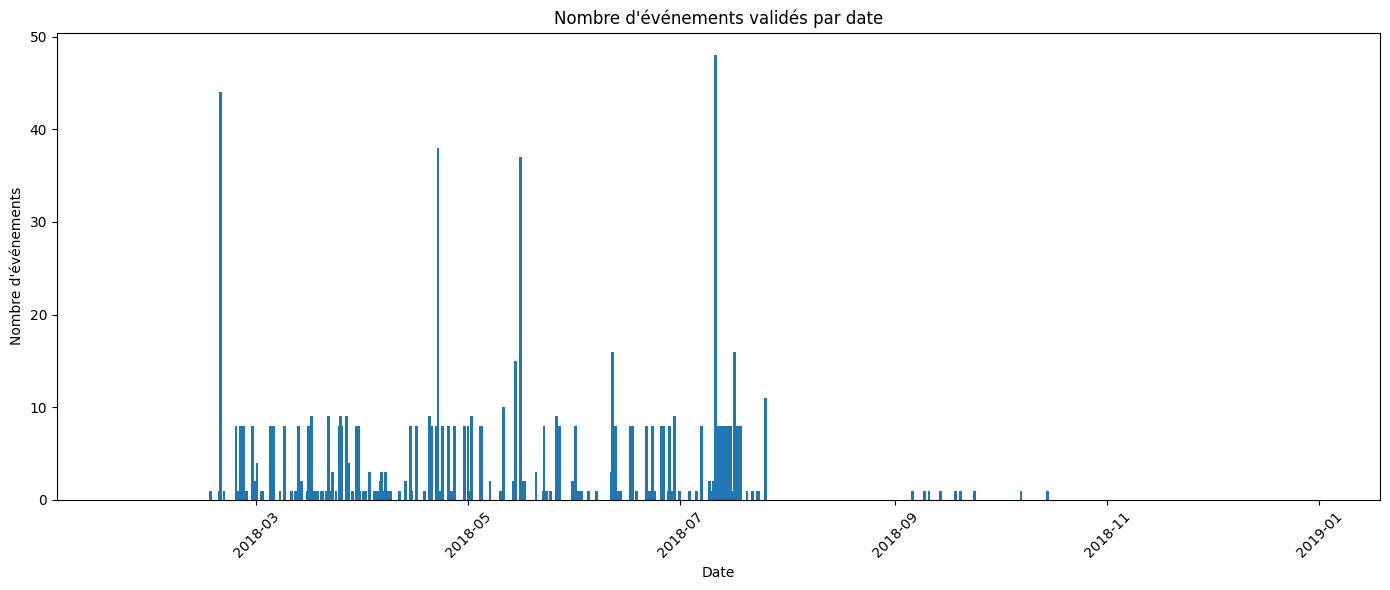

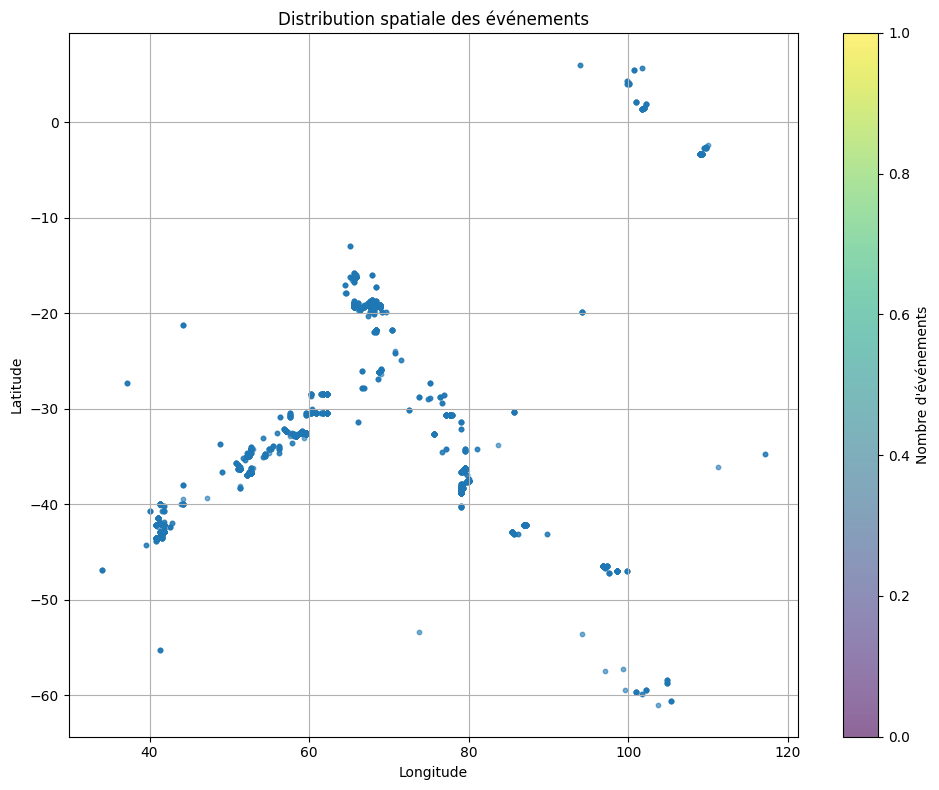

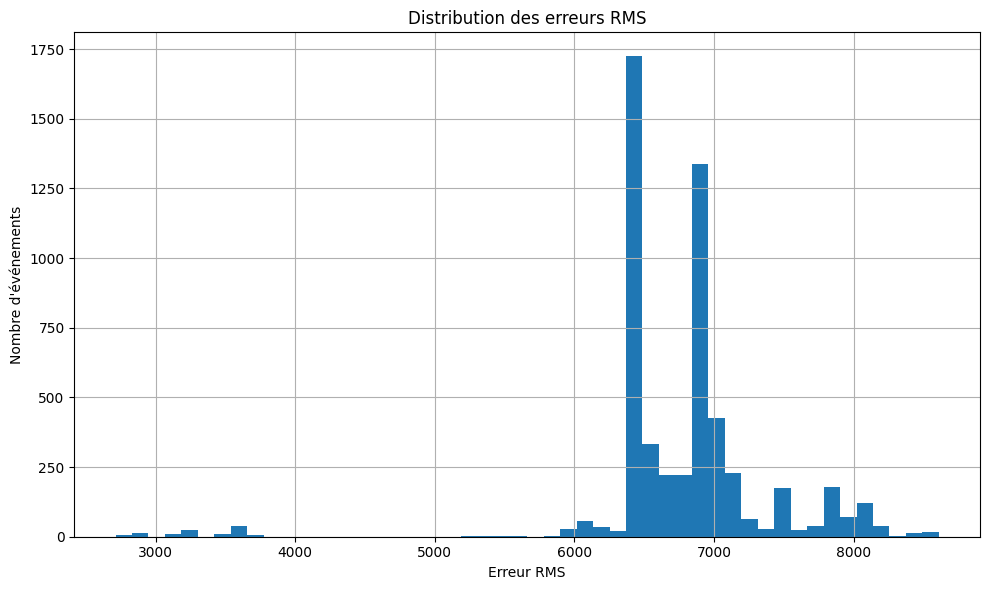

Statistiques des erreurs RMS:
  Min: 2712.2659
  Max: 8610.3225
  Moyenne: 6763.8377
  Médiane: 6838.9523


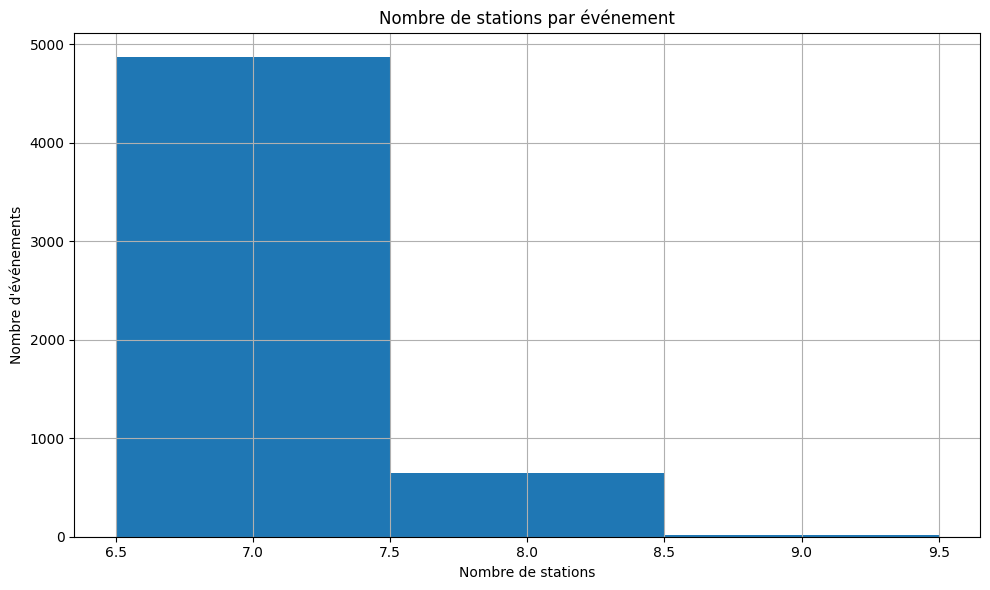

KeyError: 'estimated_error_sec'

In [23]:
#!/usr/bin/env python3
"""
visualize_results.py

Script pour visualiser et analyser les résultats des associations validées
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os

# Chemin vers le fichier résultat
RESULT_FILE = "F:/Association/validated/s_-60-5,35-120,350,0.8,0.6_final.npy"
# Pour visualiser un checkpoint partiel:
# RESULT_FILE = "/home/rsafran/PycharmProjects/toolbox/data/detection/association/validated/2018/s_-60--12.4,35-100,350,0.8,0.5_partial_50.npy"

def load_and_summarize():
    """Charge et résume les données"""
    data = np.load(RESULT_FILE, allow_pickle=True).item()

    print(f"Loaded data with {len(data)} dates")

    # Statistiques générales
    total_events = sum(len(events) for events in data.values())
    print(f"Total validated events: {total_events}")

    # Résumé par date
    date_summary = {date: len(events) for date, events in data.items()}
    dates = sorted(date_summary.keys())

    return data, date_summary, dates

def plot_events_by_date(date_summary, dates):
    """Affiche le nombre d'événements par date"""
    plt.figure(figsize=(14, 6))
    plt.bar(dates, [date_summary[d] for d in dates])
    plt.title("Nombre d'événements validés par date")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'événements")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("events_by_date.png")
    plt.show()

def plot_event_locations(data):
    """Affiche la distribution spatiale des événements"""
    # Extraire les coordonnées de tous les événements
    all_lats = []
    all_lons = []

    for date, events in data.items():
        for event in events:
            lat, lon = event['source_point']
            all_lats.append(lat)
            all_lons.append(lon)

    plt.figure(figsize=(10, 8))
    plt.scatter(all_lons, all_lats, s=10, alpha=0.6)
    plt.title("Distribution spatiale des événements")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.colorbar(label="Nombre d'événements")
    plt.tight_layout()
    plt.savefig("event_locations.png")
    plt.show()

def plot_rms_error_histogram(data):
    """Affiche l'histogramme des erreurs RMS"""
    all_errors = []

    for date, events in data.items():
        for event in events:
            all_errors.append(event['weighted_rms_error'])

    plt.figure(figsize=(10, 6))
    plt.hist(all_errors, bins=50)
    plt.title("Distribution des erreurs RMS")
    plt.xlabel("Erreur RMS")
    plt.ylabel("Nombre d'événements")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("rms_error_hist.png")
    plt.show()

    print(f"Statistiques des erreurs RMS:")
    print(f"  Min: {min(all_errors):.4f}")
    print(f"  Max: {max(all_errors):.4f}")
    print(f"  Moyenne: {sum(all_errors)/len(all_errors):.4f}")
    print(f"  Médiane: {sorted(all_errors)[len(all_errors)//2]:.4f}")

def plot_stations_per_event(data):
    """Affiche le nombre de stations par événement"""
    stations_count = []

    for date, events in data.items():
        for event in events:
            stations_count.append(event['num_stations'])

    plt.figure(figsize=(10, 6))
    plt.hist(stations_count, bins=range(min(stations_count), max(stations_count)+2), align='left')
    plt.title("Nombre de stations par événement")
    plt.xlabel("Nombre de stations")
    plt.ylabel("Nombre d'événements")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("stations_per_event.png")
    plt.show()

def export_to_csv(data):
    """Exporte les résultats dans un fichier CSV"""
    rows = []

    for date, events in data.items():
        for idx, event in enumerate(events):
            lat, lon = event['source_point']
            rows.append({
                'date': date,
                'event_index': idx,
                'latitude': lat,
                'longitude': lon,
                'origin_time': event['origin_time'],
                'rms_error': event['estimated_error_sec'],
                'num_stations': event['num_stations']
            })

    df = pd.DataFrame(rows)
    csv_path = os.path.splitext(RESULT_FILE)[0] + '.csv'
    df.to_csv(csv_path, index=False)
    print(f"Results exported to {csv_path}")

    return df

if __name__ == "__main__":
    data, date_summary, dates = load_and_summarize()

    # Générer les visualisations
    plot_events_by_date(date_summary, dates)
    plot_event_locations(data)
    plot_rms_error_histogram(data)
    plot_stations_per_event(data)

    # Exporter vers CSV
    df = export_to_csv(data)

    # Afficher les 10 premiers événements
    print("\nAperçu des 10 premiers événements:")
    print(df.head(10))